In [2]:
%pip install imageio 

Note: you may need to restart the kernel to use updated packages.


In [16]:
import cv2
import glob
import copy
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from pprint import pprint as pp

#test

In [17]:
def load_images(filenames):
    return [imageio.imread(filename) for filename in filenames]

In [18]:
filenames = list(sorted(glob.glob("./left/*.jpg")))
imgs = load_images(filenames)

In [19]:
print(filenames)

['./left/left_000.jpg', './left/left_001.jpg', './left/left_002.jpg', './left/left_003.jpg', './left/left_004.jpg', './left/left_005.jpg', './left/left_006.jpg', './left/left_007.jpg', './left/left_008.jpg', './left/left_009.jpg', './left/left_010.jpg', './left/left_011.jpg', './left/left_012.jpg', './left/left_013.jpg', './left/left_014.jpg', './left/left_015.jpg', './left/left_016.jpg', './left/left_017.jpg', './left/left_018.jpg']


Template detection: 
The function cv2.findChessboardCorners of OpenCV function finds the calibration template in an image and returns a tuple of two elements. The first element is 0 if it failed to successfully detect the template, and is 1 otherwise. The second element contains the coordinates of the corners of the calibration template, which are only valid if the detection was successful, i.e. if the first element of the tuple is 1

In [20]:
# We will execute findChessboardCorners for each image to find the corners
corners = [cv2.findChessboardCorners(i, (8,6)) for i in imgs]

In [21]:
# OPTIONAL => cornerSubPix is a destructive function. so we need to copy corners to avoid data loss
corners2 = copy.deepcopy(corners)

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
# Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# For each image and corners we are going to use cornerSubPix
cornersRefined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_grey, corners2)]
# pp(cornersRefined)

Use cv2.drawChessboardCorners to draw the corners detected in the previous exercise. Apply it to all images that were correctly detected. Ignore the rest.

In [23]:
# OPTIONAL => drawChessboardCorners is a destructive function. so we need to copy corners to avoid data loss
imgs2 = copy.deepcopy(imgs)

# We are going to draw the corners if we have found them
tmp = [cv2.drawChessboardCorners(img, (8,6), cor[1], cor[0]) for img, cor in zip(imgs2, corners) if cor[0]]

In [24]:
print(type(imgs2), len(imgs2))


<class 'list'> 19


In [25]:
for i, img in enumerate(imgs2):
    if img is None or img.size == 0:
        print(f"Image at index {i} is empty or None.")
    else:
        print(f"Image at index {i} has shape {img.shape}.")


Image at index 0 has shape (240, 320, 3).
Image at index 1 has shape (240, 320, 3).
Image at index 2 has shape (240, 320, 3).
Image at index 3 has shape (240, 320, 3).
Image at index 4 has shape (240, 320, 3).
Image at index 5 has shape (240, 320, 3).
Image at index 6 has shape (240, 320, 3).
Image at index 7 has shape (240, 320, 3).
Image at index 8 has shape (240, 320, 3).
Image at index 9 has shape (240, 320, 3).
Image at index 10 has shape (240, 320, 3).
Image at index 11 has shape (240, 320, 3).
Image at index 12 has shape (240, 320, 3).
Image at index 13 has shape (240, 320, 3).
Image at index 14 has shape (240, 320, 3).
Image at index 15 has shape (240, 320, 3).
Image at index 16 has shape (240, 320, 3).
Image at index 17 has shape (240, 320, 3).
Image at index 18 has shape (240, 320, 3).


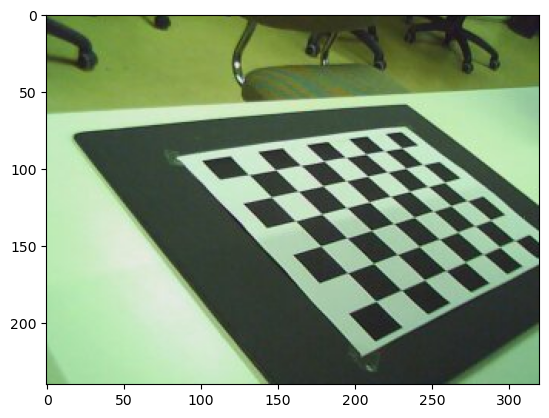

In [26]:
# Original Image
plt.figure()
plt.imshow(imgs[0])

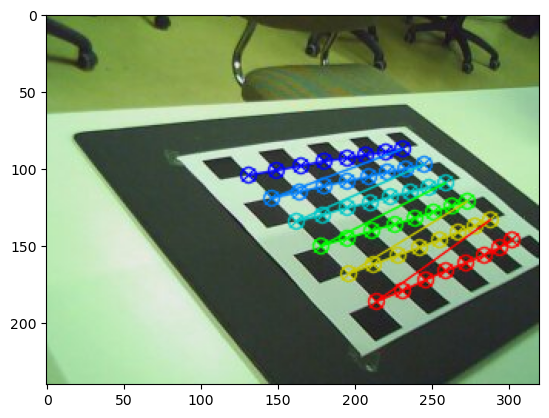

In [27]:
# Original Image
plt.figure()
plt.imshow(imgs2[0])

very important to take into account that the coordinates of the corners in the system of scene reference should be given in the same order as in which they were detected in each of the images

the function get_chessboard_points (chessboard_shape, dx, dy) that will generate an array of NumPy (that is, an ndarray) of size  
N
×
3
  with the coordinates  
(
x
,
y
,
z
)
  of the corners of the calibration template in the reference system of the scene.  
N
  is the number of corners in the template.

For the template used in this lab, both values they are  
30
m
m

In [28]:
def get_chessboard_points(chessboard_shape, dx, dy):
    return [[(i%chessboard_shape[0])*dx, (i//chessboard_shape[0])*dy, 0] for i in range(np.prod(chessboard_shape))]

cb_points = get_chessboard_points((8, 6), 30, 30)
# pp(cb_points)

In [29]:
# We are going to retrieve existing corners (cor[0] == True)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matrix with the coordinates of the corners
real_points = get_chessboard_points((8, 6), 30, 30)

# We are going to convert our coordinates list in the reference system to numpy array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convert the corners list to array
image_points = np.asarray(valid_corners, dtype=np.float32)

# Use the correct image size as (width, height)
image_size = (imgs[1].shape[1], imgs[1].shape[0])

# Set flag to fix k3 (the third radial distortion coefficient) to 0
flags = cv2.CALIB_FIX_K3

# Calibrate the camera with the flag to prevent overfitting with k3
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    object_points, image_points, image_size, None, None, flags=flags
)

# Calculate extrinsic matrices using Rodrigues and translation vectors
extrinsics = [
    np.hstack((cv2.Rodrigues(rvec)[0], tvec)) for rvec, tvec in zip(rvecs, tvecs)
]

# Save the calibration file
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics, dist_coeffs=dist_coeffs)

# Lets print some outputs
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:\n", dist_coeffs)
print("rms:\n", rms)

Corners standard intrinsics:
 [[419.45477206   0.         152.7981165 ]
 [  0.         421.6459835  130.188684  ]
 [  0.           0.           1.        ]]
Corners standard dist_coefs:
 [[-0.05779596 -0.79391021  0.0055172  -0.00533888  0.        ]]
rms:
 0.1487411209707286


In [30]:
mean_error = 0
# Loop through each calibration image
for i in range(len(object_points)):
    # Project the 3D object points to the image plane using the estimated parameters
    projected_points, _ = cv2.projectPoints(object_points[i], rvecs[i], tvecs[i], intrinsics, dist_coeffs)
    # Compute the L2 norm (Euclidean distance) between the detected points and the projected points
    error = cv2.norm(image_points[i], projected_points, cv2.NORM_L2) / len(projected_points)
    mean_error += error

mean_error /= len(object_points)
print("Total reprojection error: {}".format(mean_error))


Total reprojection error: 0.021002740842893653
